### Plot of $h_{mle}$ vs. $\gamma$

In [71]:
import numpy as np
import pandas as pd
import scipy as sp
from h_eq import solve_kappa
import warnings
warnings.filterwarnings('ignore')
from plotnine import *
warnings.resetwarnings()
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Find hmle
nvals = 12
gamma_values = np.arange(0, nvals)*(40 / nvals)
hmle_values = np.zeros((nvals,))
beta0 = 0
for i, gamma in enumerate(gamma_values):
    print(f"At gamma={gamma}")
    hmle_values[i] = solve_kappa(beta0=beta0, gamma0=gamma)


At gamma=0.0
At gamma=3.3333333333333335
At gamma=6.666666666666667
At gamma=10.0
At gamma=13.333333333333334
At gamma=16.666666666666668
At gamma=20.0
At gamma=23.333333333333336
At gamma=26.666666666666668
At gamma=30.0
At gamma=33.333333333333336
At gamma=36.66666666666667


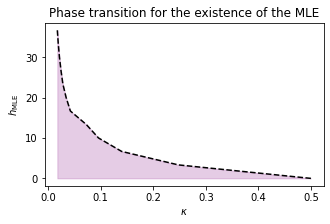

In [75]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.plot(hmle_values, gamma_values, color='black', linestyle='dashed')
ax.fill_between(hmle_values, gamma_values, color='purple', alpha=0.2)
ax.set(
    ylabel=r'$h_{\mathrm{MLE}}$',
    xlabel=r'$\kappa$',
    title='Phase transition for the existence of the MLE'
)
plt.savefig("figures/hmle.png", dpi=500, bbox_inches='tight')

### Plot of $\alpha_{\star}, \lambda_{\star},\kappa_{\star}$

/home/asher/.local/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


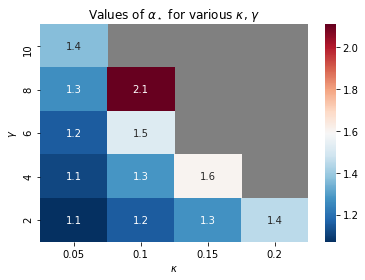

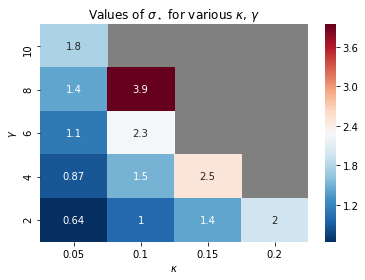

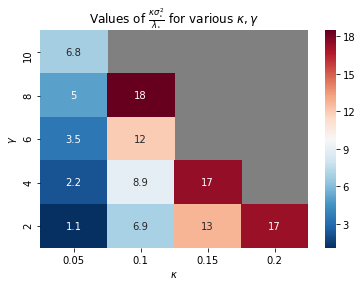

In [132]:
param_data = pd.read_csv('cache/params.csv', sep=',')
kvals = param_data['kappa'].unique()
gamma_vals = sorted(param_data['gamma'].unique(), key=lambda x: -1*x)
param_data

def construct_heatmap(param_name, title=None, ax=None):
    df = pd.DataFrame(index=kvals, columns=gamma_vals)
    for i, row in param_data.iterrows():
        df.loc[row['kappa'], row['gamma']] = float(row[param_name])

    if ax is None:
        fig, ax = plt.subplots()
    g = sns.heatmap(
        df.astype('float32').T,
        annot=True,
        cmap='RdBu_r', 
        ax=ax
    )
    g.set_facecolor('gray')
    if title is None:
        title = rf"Values of $\{param_name}_\star$ for various $\kappa$, $\gamma$"
    ax.set(
        xlabel=r'$\kappa$',
        ylabel=r'$\gamma$',
        title=title
    )

    return df


## Plot for alpha
construct_heatmap('alpha')
plt.savefig("figures/alpha.png", dpi=500, bbox_inches='tight')
plt.show()
construct_heatmap('sigma')
plt.savefig("figures/sigma.png", dpi=500, bbox_inches='tight')
plt.show()
param_data['inflation'] = param_data.index * (param_data['sigma']**2 / param_data['lambda']) 
construct_heatmap(
    'inflation', 
    title=r"Values of $\frac{\kappa \sigma_{\star}^2}{\lambda_{\star}}$ for various $\kappa, \gamma$"
)
plt.savefig("figures/inflation.png", dpi=500, bbox_inches='tight')
plt.show()

### Plotting for Simulation Results --- Well-Specified Setting

In [185]:
### First simulation plot
# Data is in 10 pieces, labelled by timestamp
files = ['576', '944', '1323', '1697', '2064', '2429','2844', '3261', '3653', '4068']
sim1_df = pd.DataFrame()
sim1_lrt = pd.DataFrame()
for file in files:
    sim1_df = pd.concat([sim1_df, pd.read_csv(f"cache/{file}_results.csv")], axis=0)
    sim1_lrt = pd.concat(
        [sim1_lrt, pd.read_csv(f"cache/{file}_results_lrt.csv")],
        axis=0
    )

sim1_df['adjusted'] = sim1_df['adj'].apply(lambda x: 'Adjusted' if x else 'Classical')
sim1_df['null_status'] = sim1_df['null'].apply(lambda x: 'Null' if x else 'Non-Null')
    
    
zpval_plot = (ggplot(sim1_df, aes(x='p.value', fill='adjusted')) +
   geom_histogram(
     aes(y='0.1*..density..'),
     breaks=np.arange(0, 11)/10,
     alpha=0.8,
     color='black',
   ) +
   facet_grid("null_status~adjusted", scales='free', labeller='label_value') +
   labs(x='p-value', y='Proportion') +
   scale_fill_manual(values=["blue", "red"]) +
   theme(legend_position='none', figure_size=(5,2)) + 
   labs(
       title="Classical and adjusted Z-statistic p-values"
    )
)
zpval_plot.save(filename='figures/sim1pvals.png', dpi=500)

/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/sim1pvals.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [186]:
subs = sim1_lrt.melt(id_vars='variable', var_name='adjusted', value_name='p.value')
lrt_pval_plot = (ggplot(subs, aes(x='p.value', fill='adjusted')) +
   geom_histogram(
     aes(y='0.1*..density..'),
     breaks=np.arange(0, 11)/10,
     alpha=0.8,
     color='black',
   ) +
   facet_grid("~adjusted", scales='free', labeller='label_value') +
   labs(x='p-value', y='Proportion') +
   scale_fill_manual(values=["blue", "red"]) +
   theme(legend_position='none', figure_size=(5,1)) + 
   labs(
       title="Classical and adjusted LRT p-values"
    )
)
lrt_pval_plot.save("figures/sim1lrt.png", dpi=500)

/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 1 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/sim1lrt.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


### Robustness Plots

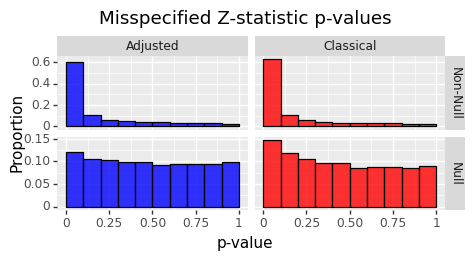

<ggplot: (-9223363261979960814)>


/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/sim2pvals.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


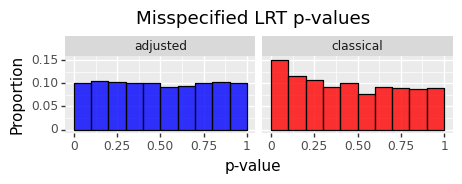

<ggplot: (8774798291562)>


/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 1 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/asher/.local/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/sim2lrt.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [184]:
### Robustness simulation plots
try:
    del sim1_df
    del sim1_lrt
except:
    pass

# Data is in 10 pieces, labelled by timestamp
files = ['6898', '7763', '8204', '8653', '9094', '9503', '10001','10894', '11339', '11798']
sim2_df = pd.DataFrame()
sim2_lrt = pd.DataFrame()
for file in files:
    sim2_df = pd.concat([sim2_df, pd.read_csv(f"cache/{file}_results.csv")], axis=0)
    sim2_lrt = pd.concat(
        [sim2_lrt, pd.read_csv(f"cache/{file}_results_lrt.csv")],
        axis=0
    )

sim2_df['adjusted'] = sim2_df['adj'].apply(lambda x: 'Adjusted' if x else 'Classical')
sim2_df['null_status'] = sim2_df['null'].apply(lambda x: 'Null' if x else 'Non-Null')
    
    
zpval_plot = (ggplot(sim2_df, aes(x='p.value', fill='adjusted')) +
   geom_histogram(
     aes(y='0.1*..density..'),
     breaks=np.arange(0, 11)/10,
     alpha=0.8,
     color='black',
   ) +
   facet_grid("null_status~adjusted", scales='free', labeller='label_value') +
   labs(x='p-value', y='Proportion') +
   scale_fill_manual(values=["blue", "red"]) +
   theme(legend_position='none', figure_size=(5,2)) + 
   labs(
       title="Misspecified Z-statistic p-values"
    )
)
print(zpval_plot)
zpval_plot.save(filename='figures/sim2pvals.png', dpi=500)

subs = sim2_lrt.melt(id_vars='variable', var_name='adjusted', value_name='p.value')
lrt_pval_plot = (ggplot(subs, aes(x='p.value', fill='adjusted')) +
   geom_histogram(
     aes(y='0.1*..density..'),
     breaks=np.arange(0, 11)/10,
     alpha=0.8,
     color='black',
   ) +
   facet_grid("~adjusted", scales='free', labeller='label_value') +
   labs(x='p-value', y='Proportion') +
   scale_fill_manual(values=["blue", "red"]) +
   theme(legend_position='none', figure_size=(5,1)) + 
   labs(
       title="Misspecified LRT p-values"
    )
)
print(lrt_pval_plot)
lrt_pval_plot.save("figures/sim2lrt.png", dpi=500)

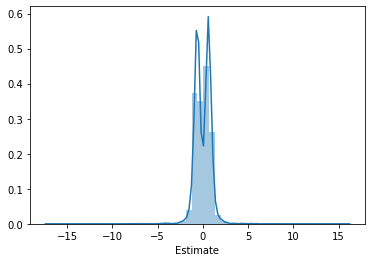

beta
-0.34641   -0.634714
 0.00000    0.001694
 0.34641    0.634111
Name: Estimate, dtype: float64

In [174]:
sns.distplot(robustness_data.loc[(robustness_data['adj']) & (~robustness_data['null']), 'Estimate'])
plt.show()
robustness_data.loc[robustness_data['adj']].groupby(['beta'])['Estimate'].mean()

In [173]:
robustness_data.loc[(robustness_data['adj'])]

,Estimate,std,z.value,p.value,beta,variable,adj,null,adjusted,null_status
76,-0.280880,0.221741,-1.266702,0.205262,-0.34641,1,True,False,Adjusted,Non-Null
77,-0.880217,0.272570,-3.229321,0.001241,-0.34641,2,True,False,Adjusted,Non-Null
78,-0.440704,0.329219,-1.338634,0.180690,-0.34641,3,True,False,Adjusted,Non-Null
79,-0.624494,0.312256,-1.999945,0.045506,-0.34641,4,True,False,Adjusted,Non-Null
80,-0.596321,0.178793,-3.335263,0.000852,-0.34641,5,True,False,Adjusted,Non-Null
...,...,...,...,...,...,...,...,...,...,...
5996,-0.367173,0.208138,-1.764083,0.077718,0.00000,71,True,True,Adjusted,Null
5997,0.259507,0.197976,1.310804,0.189924,0.00000,72,True,True,Adjusted,Null
5998,-0.887411,0.456784,-1.942737,0.052048,0.00000,73,True,True,Adjusted,Null
5999,0.354468,0.480272,0.738058,0.460479,0.00000,74,True,True,Adjusted,Null


### Table 1

In [162]:
sim1means = sim1_df.groupby(['beta', 'adjusted'])['Estimate'].mean().unstack()
rmeans = robustness_data.groupby(['beta', 'adjusted'])['Estimate'].mean().unstack()

rmeans['Setting'] = 'Misspecified'
sim1means['Setting'] = 'Well-Specified'
rmeans = rmeans.reset_index()
sim1means = sim1means.reset_index()

In [163]:
both_results = pd.concat([rmeans, sim1means], axis=0)
both_results

adjusted,beta,Adjusted,Classical,Setting
0,-0.34641,-0.634714,-0.949522,Misspecified
1,0.00000,0.001694,0.002159,Misspecified
2,0.34641,0.634111,0.944103,Misspecified
0,-0.34641,-0.359285,-0.463468,Well-Specified
1,0.00000,0.000048,0.000042,Well-Specified
2,0.34641,0.358928,0.462902,Well-Specified


In [166]:
# print(all_df.columns)
# subset = all_df.loc[np.abs(all_df['beta']) < 1]
# breaks = np.arange(0,10)/5 - 5
# subset= np.around(beta, 2)

# nnul_coeff_plot = (ggplot(subset, aes(x='Estimate', fill='adjusted')) +
#    geom_histogram(breaks=breaks) +
#    facet_grid("beta~adjusted", scales='free', labeller='label_value') +
#    #labs(x='p-value', y='Count over 400 replications') +
#    scale_fill_manual(values=["blue", "red"]) +
#    theme(legend_position='none', figure_size=(5,3)) + 
#    labs(
#        title="Classical and adjusted Z-statistic p-values"
#     )
# )

# print(nnul_coeff_plot)

### Preprocessing for SEOCOM dataset

In [76]:
# Load
Xsecom = pd.read_csv('raw/secom.data', sep=' ', header=None)
ysecom = pd.read_csv('raw/secom_labels.data', sep=' ', header=None)

In [77]:
# Process y data (this is easy)
y = ysecom[0].copy()
y[y == -1] = 0

# Process X data (slightly trickier)
# (1) Replace missing values with their mean
X = Xsecom.fillna(Xsecom.mean(axis=0))
# (2) Scale and center
stdev = X.std(axis=0)
#stdev[stdev == 0] = 1
X = (X - X.mean()) / stdev
# (3) Eliminate columns which only have one unique value or NaNs
X = X.loc[:, (stdev.notnull()) & (stdev != 0)]
assert(X.isnull().sum().sum() == 0)

In [179]:
# Save to cache
X.to_csv('processed/secomX.csv', header=True)
y.to_csv('processed/secomy.csv', header=False)

In [211]:
# Turns out the MLE doesn't exist! We use hierarchical clustering to deal with this.
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as ssd

# Create correlation tree
corr_matrix = np.corrcoef(X.T)
dist_matrix = np.around(1 - np.abs(corr_matrix), decimals=7)
condensed_dist_matrix = ssd.squareform(dist_matrix)
link = hierarchy.average(condensed_dist_matrix)

# "Cut" the correlation tree and obtain cluster representatives
groups = hierarchy.fcluster(link, t=300, criterion='maxclust')
representatives = []
for group_id in np.unique(groups):
    representatives.append(np.min(np.where(groups==group_id)))
    
# Clustered data
Xclust = X.iloc[:, representatives]
Xclust.to_csv('processed/clusteredX.csv')

In [ ]:
X